<a href="https://colab.research.google.com/github/TTsay/tutorials/blob/master/TSGM_augmentations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Augmentations with TSGM

Augmentations have become an indispensable component in the realm of computer vision pipelines. However, their popularity hasn't reached the same heights in other domains, such as time series. In this tutorial, I will delve into the world of time series augmentations, shedding light on their significance and providing concrete examples of their application using the powerful generative time series modeling library, TSGM.

Our starting point is a dataset denoted $(X, y)$. Here, $x_i \in X$ are multivariate (meaning, each time point is a multiple dimensional feature vector) time series, and $y$ are labels. Predicting labels $y$ is called a downstream task. Our goal is to use $(X, y)$ to produce additional samples $(\hat{X}, \hat{y})$, which could help us solve the downstream task more effectively (in terms of predictive performance or robustness). For simplicity, we won't work with labels in this tutorial, but the methods we describe here are straightforward to generalize to the case with labels, and the software implementations we use are easily extended to the supervised case by adding additional parameters to the `.generate` method (see examples below).

Without further ado, let's consider time series augmentations one by one.
In TSGM, all augmentations are neatly organized in `tsgm.models.augmentations`, and you can check out the comprehensive documentation available at https://tsgm.readthedocs.io/en/latest/guides/introduction.html#augmentations
Now, let's kickstart coding examples by installing tsgm:
```bash
pip install tsgm
```

In [ ]:
!pip install tsgm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 7.6 MB/s eta 0:00:00
  Created wheel for tsgm: filename=tsgm-0.0.5-py3-none-any.whl size=57108 sha256=92b7231680617351216c6bf9616d3c2b4f23dfbaaefa9aa063a70a3e38735fea
  Stored in directory: /root/.cache/pip/wheels/f3/04/27/7d080cdaf3c4a00fc1accf8066ad2581cdd3da04b6b381c411
  Created wheel for antropy: filename=antropy-0.1.6-py3-none-any.whl size=16879 sha256=9fc2ed37bb71cc3f68f2fd1f6c92eab2bc229519ee38c377ecec3aac8ed1ceb1
  Stored in directory: /root/.cache/pip/wheels/98/22/06/e91d7bb213c7133d5e2eb34258623e1e19928d5f05e1

In [ ]:
import tsgm

Moving forward, we import tsgm, and load an exemplary dataset. A tensor `X` now contains 100 sine time series of length 64, with 2 features each. With random shift, frequencies, and amplitudes (maximum amplitude is 20).

In [ ]:
%load_ext autoreload
%autoreload 2
from IPython.display import SVG, display, Image

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from tensorflow import keras





def plot(timesteps, X, plot_id=1, title="Original"):
    plt.subplot(1, 2, plot_id)
    for sample_id in range(X.shape[0]):
        plt.plot(timesteps, X[sample_id, :, 0], label=f"Sample #{sample_id}")
    plt.title(title)
    plt.legend()


def plot_samples_aug(X, Xaug, n_samples=5):
    timesteps = np.arange(0, X.shape[1], 1)
    sample_ids = random.sample(range(X.shape[0]), n_samples)
    sample_ids_aug = random.sample(range(Xaug.shape[0]), n_samples)

    plot(timesteps, X[sample_ids])
    plot(timesteps, Xaug[sample_ids_aug], title="Synthetic", plot_id=2)
    plt.savefig("synthetic_example.jpg")
    plt.show()


In [ ]:
X = tsgm.utils.gen_sine_dataset(100, 64, 2, max_value=20)

## Jittering / Gaussian noise

Time series data are augmented with random Gaussian noise ([Wikipedia](https://en.wikipedia.org/wiki/Gaussian_noise))

$$x_i = x_i + \mathcal{N}(0, \sigma).$$

In tsgm, Gaussian noise augmentation can be applied as follows:


In [ ]:
aug_model = tsgm.models.augmentations.GaussianNoise()
samples = aug_model.generate(X=X, n_samples=10, variance=0.2)

The idea behind Gaussian noise augmentation is that adding a small amount of jittering to time series probably will not change it significantly but will increase the amount of such noisy samples in our dataset. It often makes the downstream models more robust to noisy samples or improves predictive performance.
The hyperparameters of Gaussian noise and the way of adding the noise (e.g., Gaussian noise can increase towards the end of a time series) is a difficult question and depends on a particular dataset and downstream problem. It is often worth experimenting and seeing how those parameters affect the performance of the target model.
Here, we provide a visualization of samples from the original sine dataset and augmented samples.

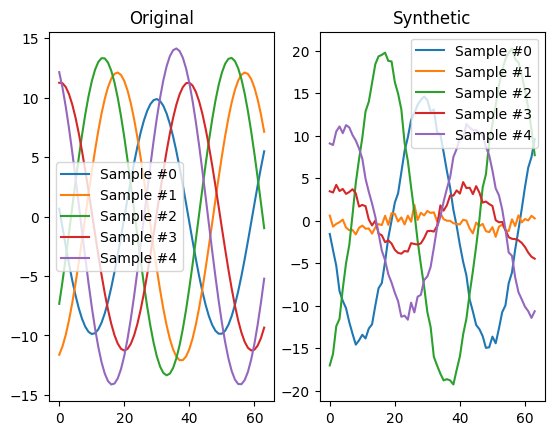

In [ ]:
plot_samples_aug(X, samples)

## Shuffle Features

Another approach to time series augmentation is simply shuffly the features. This approach is suitable only for particular multivariate time series, where they are invariant to all or particular permutations of features. For instance, it can be applied to time series where each feature represents same independent measurements from various sensors.

To illustrate this method, let us consider 5 identical sensors ($S_1, S_2, S_3, S_4, \text{and } S_5$). We can see that sensors 1-4 are probably exchangeable with respect to rotation. Then it makes sense to try augmenting data with feature shufle with respect to rotations of $S_1, \ldots, S_4$ sensors.

In [ ]:
#Image("./images/shuffle_features.jpg", height=256, width=256)

Similarly to the previous example, the augmentation can work as follows:

In [ ]:
aug_model = tsgm.models.augmentations.Shuffle()
samples = aug_model.generate(X=X, n_samples=3)

Here, we show one sample from a timeseries with 5 features, and an augmented sample, analogously to the image above.

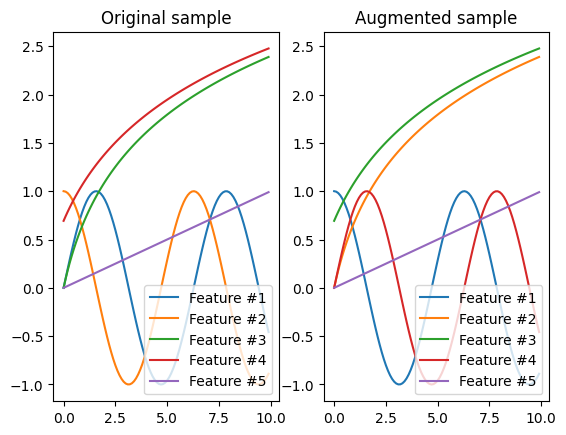

In [ ]:
timesteps = np.arange(0, 10, 0.1)
sample = np.stack([np.sin(timesteps), np.cos(timesteps), np.log(timesteps + 1), np.log(timesteps + 2), timesteps / 10])
plt.subplot(1, 2, 1)
for feature_id in range(5):
    plt.plot(timesteps, sample[feature_id], label=f"Feature #{feature_id + 1}")
plt.title("Original sample")
plt.legend()

permutation = [1, 2, 3, 0, 4]
sample = sample[permutation]
plt.subplot(1, 2, 2)
for feature_id in range(5):
    plt.plot(timesteps, sample[feature_id], label=f"Feature #{feature_id + 1}")
plt.title("Augmented sample")
plt.legend()
plt.show()

## Slice and shuffle

Slice and shuffle augmentation [3] cuts a time series into slices and shuffles those pieces. This augmentation can be performed for time series that exhibit some form of invariance over time. For instance, imagine a time series measured from wearable devices for several days. The good strategy for this case is to slice time series by days and, by shuffling those days, get additional samples. Slice and shuffle augmentation is visualized in the following image:

In [ ]:
#Image("./images/slice_and_shuffle.jpg", height=1024, width=512)

In [ ]:
aug_model = tsgm.models.augmentations.SliceAndShuffle()
samples = aug_model.generate(X=X, n_samples=10, n_segments=3)

Let's view augmented and original samples as a visualization:

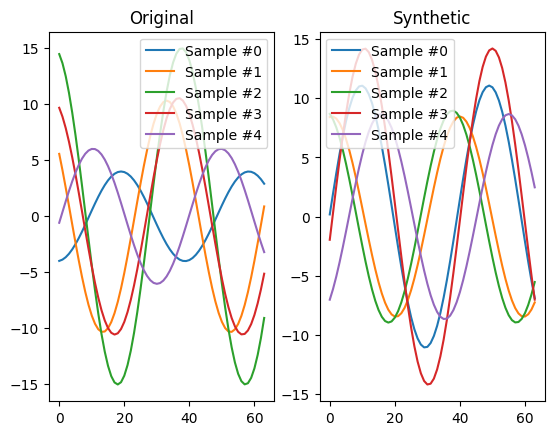

In [ ]:
plot_samples_aug(X, samples)


## Magnitude Warping

Magnitude warping [3] changes the magnitude of each sample in a time series dataset by multiplication of the original time series with a cubic spline curve. This process scales the magnitude of time series, which can be beneficial in many cases, such as our synthetic example with sines `n_knots` number of knots at random magnitudes distributed as $\mathcal{N}(1, \sigma)$ where $\sigma$ is set by a parameter `sigma` in function `.generate`.

In [ ]:
aug_model = tsgm.models.augmentations.MagnitudeWarping()
samples = aug_model.generate(X=X, n_samples=10, sigma=1)

Here is an example of original data and augmented samples generated with `MagnitudeWarping`.

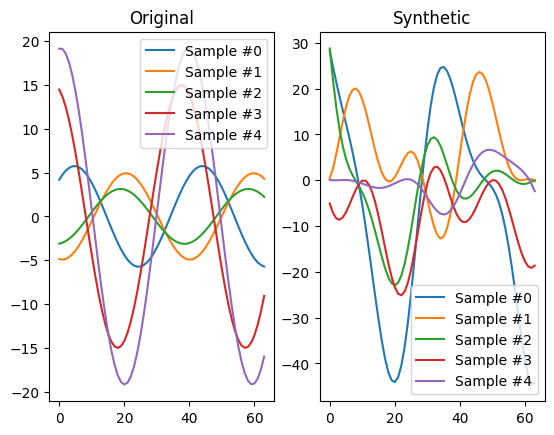

In [ ]:
plot_samples_aug(X, samples)

## Window Warping

In this technique [4], the selected windows in time series data are either speeding up or down. Then, the whole resulting time series is scaled back to the original size in order to keep the timesteps at the original length. See an example of such augmentation below:

In [ ]:
#Image("./images/window_warping.jpg", height=512, width=1024)

Such augmentation can be beneficial, e.g., in modeling equipment. In such applications, sensor measurements can change the speed of change depending on how those pieces of equipment are used.


In tsgm, as always, the generation can be done via

In [ ]:
aug_model = tsgm.models.augmentations.WindowWarping()
samples = aug_model.generate(X=X, n_samples=10, scales=(0.5,), window_ratio=0.5)

An example of a generated time series can be found below.

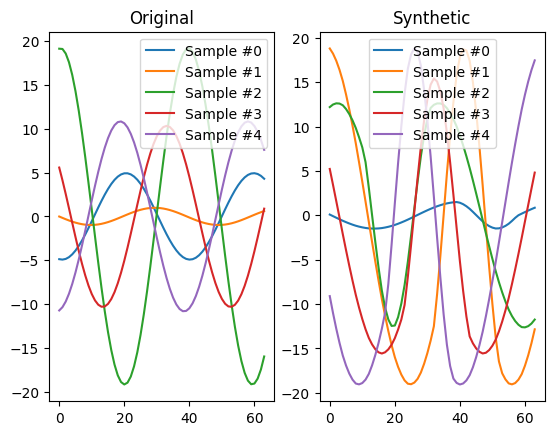

In [ ]:
plot_samples_aug(X, samples)

## Dynamic Time Warping Barycentric Average (DTWBA)

Dynamic Time Warping Barycentric Average (DTWBA)[2] is an augmentation method that is based on Dynamic Time Warping (DTW). DTW is a method of measuring similarity between time series. The idea is to "sync" those time series, as it is demonstrated in the following picture.

In [ ]:
#Image("./images/dtw.jpg", height=512, width=512)

Here, DTW is measured for two time series signals $\sin(x)$ and $\sin(2x)$. DTW measurement is shown with the white line. Also, a cross-similarity matrix is visualized.

More details on DTW computation are available at https://rtavenar.github.io/blog/dtw.html.

DTWBA goes like this:  
1. The algorithm picks one time series to initialize the DTW_BA result. This time series can either be given explicitly or can be chosen randomly from the dataset  
2. For each of the N time series, the algorithm computes DTW distance and the path (the path is the mapping that minimizes the distance)  
3. After computing all $N$ DTW distances, the algorithm updates the DTWBA result by doing the average with respect to all the paths found above
4. The algorithm repeats steps (2) and (3) until the DTWBA result converges

A reference implementation can be found in [tslearn](https://github.com/tslearn-team/tslearn/blob/main/tslearn/barycenters/dba.py#L60), and a description can be found in [2].

In tsgm, the samples can be generated as follows

In [ ]:
aug_model = tsgm.models.augmentations.DTWBarycentricAveraging()
initial_timeseries = random.sample(range(X.shape[0]), 10)
initial_timeseries = X[initial_timeseries]
samples = aug_model.generate(X=X, n_samples=10, initial_timeseries=initial_timeseries )

In [ ]:
samples.shape

(10, 64, 2)

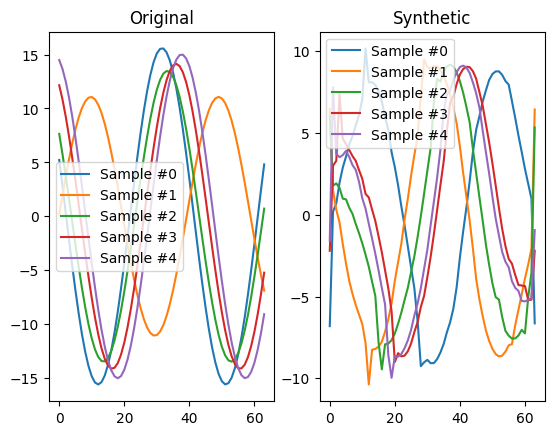

In [ ]:
plot_samples_aug(X, samples)

## Augmentation with generative machine learning models

Another approach to augmentation is to train a machine learning model on historical data and train it to generate novel synthetic samples. It is a blackbox method because it is hard to interpret how new samples were generated. Several methods can be applied in the case of time series; in particular, tsgm has VAE, GANs, and Gaussian processes. An example of the generation of synthetic time series with VAEs is

In [ ]:
n, n_ts, n_features = 1000, 64, 2
data = tsgm.utils.gen_sine_dataset(n, n_ts, n_features)
scaler = tsgm.utils.TSFeatureWiseScaler()
scaled_data = scaler.fit_transform(data)
architecture = tsgm.models.zoo["vae_conv5"](n_ts, n_features, 10)
encoder, decoder = architecture.encoder, architecture.decoder
vae = tsgm.models.cvae.BetaVAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

vae.fit(scaled_data, epochs=1, batch_size=64)
samples = vae.generate(10)

16/16 [==============================] - 10s 67ms/step - loss: 355.0752 - reconstruction_loss: 324.7551 - kl_loss: 2.4549


In [ ]:
type(samples)

tensorflow.python.framework.ops.EagerTensor

In [ ]:
samples.numpy()[:,:,:2].shape

(10, 64, 2)

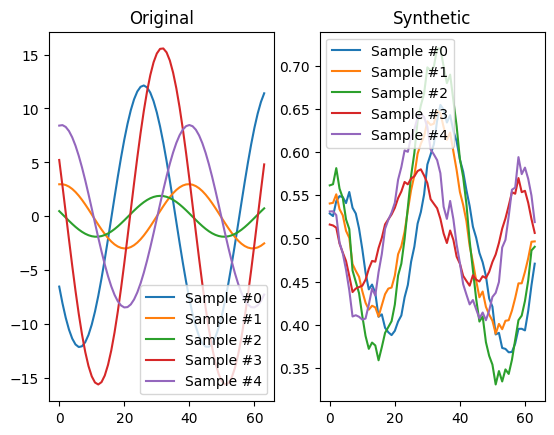

In [ ]:
plot_samples_aug(X, samples.numpy())

## Conclusion

We explored several methods for synthetic time series generation. Many of them introduce inductive biases into the model and are useful in practical settings.

How to choose? First, analyze whether your problem contains invariances. Is it invariant to random noise? Is it invariant to feature shuffling?

Next, choose a broad set of methods and verify whether any of the selected methods improve the performance of your downstream problem (tsgm has downstream performance metric: https://github.com/AlexanderVNikitin/tsgm/blob/main/tsgm/metrics/metrics.py#L133). Then, select the set of augmentation methods that gives the largest performance boost.

## References

[1] H. Sakoe and S. Chiba, “Dynamic programming algorithm optimization for spoken word recognition”. IEEE Transactions on Acoustics, Speech, and Signal Processing, 26(1), 43-49 (1978).

[2] F. Petitjean, A. Ketterlin & P. Gancarski. A global averaging method for dynamic time warping, with applications to clustering. Pattern Recognition, Elsevier, 2011, Vol. 44, Num. 3, pp. 678-693

[3] Um TT, Pfister FM, Pichler D, Endo S, Lang M, Hirche S,
Fietzek U, Kulic´ D (2017) Data augmentation of wearable sensor data for parkinson’s disease monitoring using convolutional neural networks. In: Proceedings of the 19th ACM international conference on multimodal interaction, pp. 216–220

[4] Rashid, K.M. and Louis, J., 2019. Window-warping: a time series data augmentation of IMU data for construction equipment activity identification. In ISARC. Proceedings of the international symposium on automation and robotics in construction (Vol. 36, pp. 651-657). IAARC Publications.